# Proyek Akhir Klasifikasi Gambar

Nama : Muhammad Nurul Fatwa Al Fajar

ID : mc009d5y0699

Email : mc009d5y0699@student.devacademy.id

# Import Library dan Package

In [1]:
pip install tensorflow tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 980.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import tensorflowjs as tfjs
import numpy as np
import pandas as pd
import zipfile
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
sns.set_style('darkgrid')
from IPython.display import display, HTML
from PIL import Image, ImageOps

# Data Preparations

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Tentukan path file ZIP
zip_file_path = '/content/drive/My Drive/Image Clasification Dicoding/Garbage Dataset.zip'

# Tentukan folder tujuan ekstraksi
extract_to = '/content/drive/My Drive/Image Clasification Dicoding/'

# Buat folder tujuan jika belum ada
os.makedirs(extract_to, exist_ok=True)

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"File telah diekstrak ke {extract_to}")

File telah diekstrak ke /content/drive/My Drive/Image Clasification Dicoding/


In [10]:
sdir = '/content/drive/My Drive/Image Clasification Dicoding/garbage_classification'

file_paths = []
labels = []
class_names = os.listdir(sdir)

for category in class_names:
    category_path = os.path.join(sdir, category)
    if os.path.isdir(category_path):
        file_list = os.listdir(category_path)
        for file in file_list:
            file_path = os.path.join(category_path, file)
            file_paths.append(file_path)
            labels.append(category)

file_paths_series = pd.Series(file_paths, name='file_paths')
labels_series = pd.Series(labels, name='labels')
data_frame = pd.concat([file_paths_series, labels_series], axis=1)

print(data_frame.head())
print(data_frame['labels'].value_counts())

                                          file_paths   labels
0  /content/drive/My Drive/Image Clasification Di...  battery
1  /content/drive/My Drive/Image Clasification Di...  battery
2  /content/drive/My Drive/Image Clasification Di...  battery
3  /content/drive/My Drive/Image Clasification Di...  battery
4  /content/drive/My Drive/Image Clasification Di...  battery
labels
clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64


# Data Loading

<ipython-input-12-ab889005b774>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


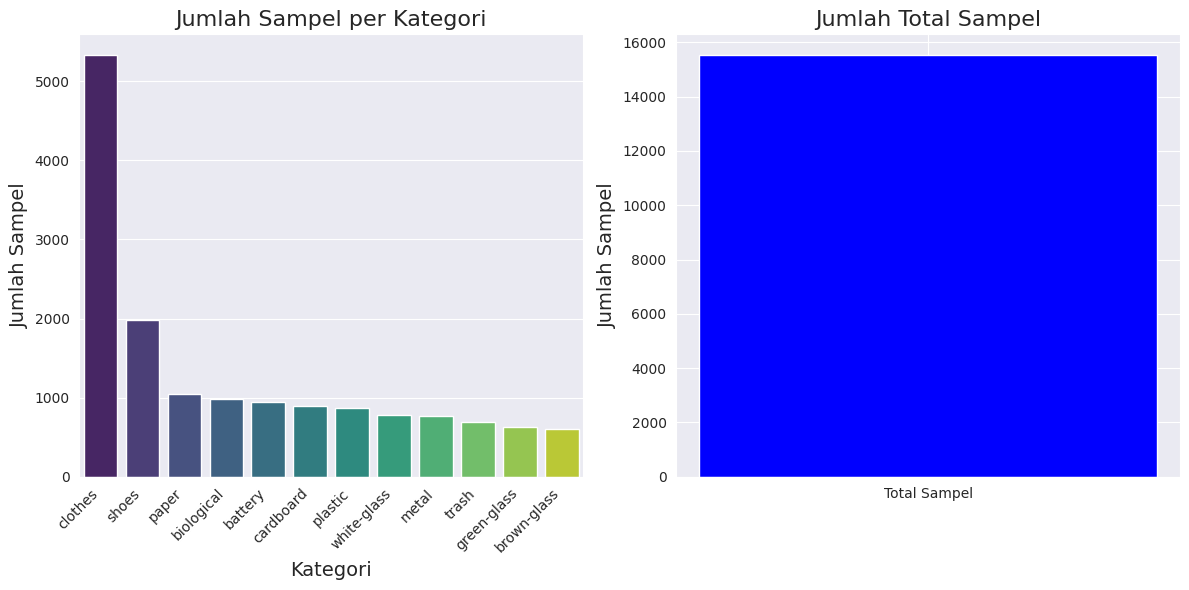

In [12]:
# Hitung jumlah sampel untuk setiap kategori
category_counts = data_frame['labels'].value_counts()
# Hitung jumlah total data
total_samples = len(data_frame)

plt.figure(figsize=(12, 6))

# Subplot 1: Jumlah Sampel Tiap Kategori
plt.subplot(1, 2, 1)
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Jumlah Sampel per Kategori', fontsize=16)
plt.xlabel('Kategori', fontsize=14)
plt.ylabel('Jumlah Sampel', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Subplot 2: Jumlah Total Sampel
plt.subplot(1, 2, 2)
plt.bar('Total Sampel', total_samples, color='blue')
plt.title('Jumlah Total Sampel', fontsize=16)
plt.ylabel('Jumlah Sampel', fontsize=14)

plt.tight_layout()
plt.show()

In [14]:
# Inisialisasi list untuk menyimpan dimensi gambar
img_widths = []
img_heights = []

# Loop melalui setiap path gambar
for filepath in data_frame['file_paths']: # Changed df to data_frame
    with Image.open(filepath) as image:
        width, height = image.size
        img_widths.append(width)
        img_heights.append(height)

# Tambahkan kolom 'width' dan 'height' pada DataFrame
data_frame['width'] = img_widths # Changed df to data_frame
data_frame['height'] = img_heights # Changed df to data_frame

# Tampilkan DataFrame
print(data_frame.head()) # Changed df to data_frame

                                          file_paths   labels  width  height
0  /content/drive/My Drive/Image Clasification Di...  battery    280     180
1  /content/drive/My Drive/Image Clasification Di...  battery    220     165
2  /content/drive/My Drive/Image Clasification Di...  battery    275     183
3  /content/drive/My Drive/Image Clasification Di...  battery    275     183
4  /content/drive/My Drive/Image Clasification Di...  battery    224     224


In [16]:
# Hitung distribusi frekuensi pasangan lebar dan tinggi
size_freq = data_frame.groupby(['width', 'height']).size().reset_index(name='count')

# Urutkan berdasarkan jumlah gambar (opsional)
size_freq = size_freq.sort_values(by='count', ascending=False)

# Tampilkan hasilnya
print(size_freq)

     width  height  count
609    400     533   2590
824    512     384   2358
245    225     225   2004
610    400     534   1077
359    275     183    691
..     ...     ...    ...
36     155     325      1
37     155     326      1
39     156     324      1
40     157     322      1
41     158     318      1

[892 rows x 3 columns]


<ipython-input-17-8d5b55ed0fda>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_size_counts['size'] = top_size_counts['width'].astype(str) + ' x ' + top_size_counts['height'].astype(str)
<ipython-input-17-8d5b55ed0fda>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='size', y='count', data=top_size_counts, palette='viridis')


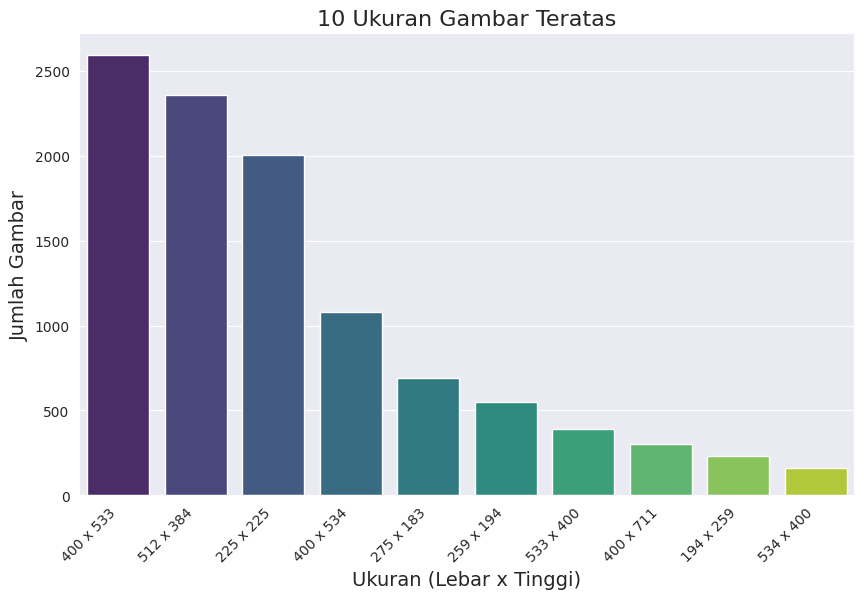

In [17]:
# Ambil 10 ukuran terbanyak untuk visualisasi
top_size_counts = size_freq.head(10)

# Gabungkan lebar dan tinggi menjadi satu label ukuran
top_size_counts['size'] = top_size_counts['width'].astype(str) + ' x ' + top_size_counts['height'].astype(str)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='size', y='count', data=top_size_counts, palette='viridis')
plt.title('10 Ukuran Gambar Teratas', fontsize=16)
plt.xlabel('Ukuran (Lebar x Tinggi)', fontsize=14)
plt.ylabel('Jumlah Gambar', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

# Data Preprocessing

Membagi Dataset

In [19]:
train_ratio = 0.8
test_ratio = 0.1
valid_ratio = test_ratio / (1 - train_ratio)

# Membagi data menjadi train, test, dan valid
train_data, temp_data = train_test_split(data_frame, train_size=train_ratio, shuffle=True, random_state=123)
test_data, valid_data = train_test_split(temp_data, train_size=valid_ratio, shuffle=True, random_state=123)

# Tampilkan panjang dataset
print('train_data length:', len(train_data), ' test_data length:', len(test_data), ' valid_data length:', len(valid_data))

train_data length: 12412  test_data length: 1551  valid_data length: 1552


In [22]:
height = 224
width = 224
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)
# The variable was changed to test_data which was defined.
data_length = len(test_data)

# Tentukan test batch size
test_batch_size = sorted([int(data_length / n) for n in range(1, data_length + 1) if data_length % n == 0 and data_length / n <= 80], reverse=True)[0]

# Tentukan jumlah test steps
test_steps = int(data_length / test_batch_size)

print('Test batch size:', test_batch_size, ' Test steps:', test_steps)

# Inisialisasi ImageDataGenerator untuk train, valid, dan test
gen = ImageDataGenerator(rescale=1. / 255)

# These were changed to use the correct dataframes
train_gen = gen.flow_from_dataframe(
    train_data, x_col='file_paths', y_col='labels', target_size=img_size, class_mode='categorical', # train_df was changed to train_data and filepaths was changed to file_paths
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
    valid_data, x_col='file_paths', y_col='labels', target_size=img_size, class_mode='categorical', # valid_df was changed to valid_data and filepaths was changed to file_paths
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

test_gen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
    test_data, x_col='file_paths', y_col='labels', target_size=img_size, class_mode='categorical', # test_df was changed to test_data and filepaths was changed to file_paths
    color_mode='rgb', shuffle=False, batch_size=test_batch_size
)

# Ambil kelas yang ada dalam dataset
classes = list(train_gen.class_indices.keys())
print(classes)

# Hitung jumlah kelas
class_count = len(classes)

Test batch size: 47  Test steps: 33
Found 12412 validated image filenames belonging to 12 classes.
Found 1552 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [24]:
def display_image_samples(gen):
    class_mapping = test_gen.class_indices
    class_names = list(class_mapping.keys())
    images, labels = next(gen)  # Ambil batch contoh dari generator
    plt.figure(figsize=(20, 20))

    total_images = len(labels)
    # Tampilkan maksimal 25 gambar
    num_images = min(total_images, 25)

    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        label_index = np.argmax(labels[i])
        class_name = class_names[label_index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')

    plt.show()

# Moddeling

In [25]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3))
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [27]:
base_model.trainable = False

In [28]:
model_name = 'xception'
print("Membangun model dengan", base_model)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Membangun model dengan <Functional name=xception, built=True>


In [29]:
epochs = 20

history = model.fit(
    x=train_gen,
    epochs=epochs,
    validation_data=valid_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


194/194 ━━━━━━━━━━━━━━━━━━━━ 129s 556ms/step - accuracy: 0.6435 - loss: 1.1595 - val_accuracy: 0.8724 - val_loss: 0.3877
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 420ms/step - accuracy: 0.8830 - loss: 0.3748 - val_accuracy: 0.8969 - val_loss: 0.3284
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 420ms/step - accuracy: 0.9055 - loss: 0.2986 - val_accuracy: 0.9143 - val_loss: 0.2890
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - accuracy: 0.9270 - loss: 0.2286 - val_accuracy: 0.9130 - val_loss: 0.2727
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 79s 406ms/step - accuracy: 0.9402 - loss: 0.1842 - val_accuracy: 0.9104 - val_loss: 0.2964
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 76s 390ms/step - accuracy: 0.9511 - loss: 0.1573 - val_accuracy: 0.9182 - val_loss: 0.3267
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 81s 384ms/step - accuracy: 0.9541 - loss: 0.1418 - val_accuracy: 0.9188 - val_loss: 0.3500
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9550 - loss: 0.1359 - va

# Eval & Visual

In [41]:
def print_in_color(txt_msg, fore_tuple, back_tuple):
    # Mencetak txt_msg dengan warna foreground sesuai fore_tuple dan background sesuai back_tuple
    # txt_msg adalah teks yang akan dicetak, fore_tuple adalah warna foreground (r, g, b), back_tuple adalah warna background (r, g, b)

    rf, gf, bf = fore_tuple
    rb, gb, bb = back_tuple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'

    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)  # Mengembalikan warna default setelah mencetak
    return

In [42]:
def tr_plot(tr_data, start_epoch):
    # Plot data pelatihan dan validasi
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    index_loss = np.argmin(vloss)  # Epoch dengan loss validasi terendah
    val_lowest = vloss[index_loss]

    index_acc = np.argmax(vacc)  # Epoch dengan akurasi validasi tertinggi
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')
    sc_label = 'Best epoch = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'Best epoch = ' + str(index_acc + 1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

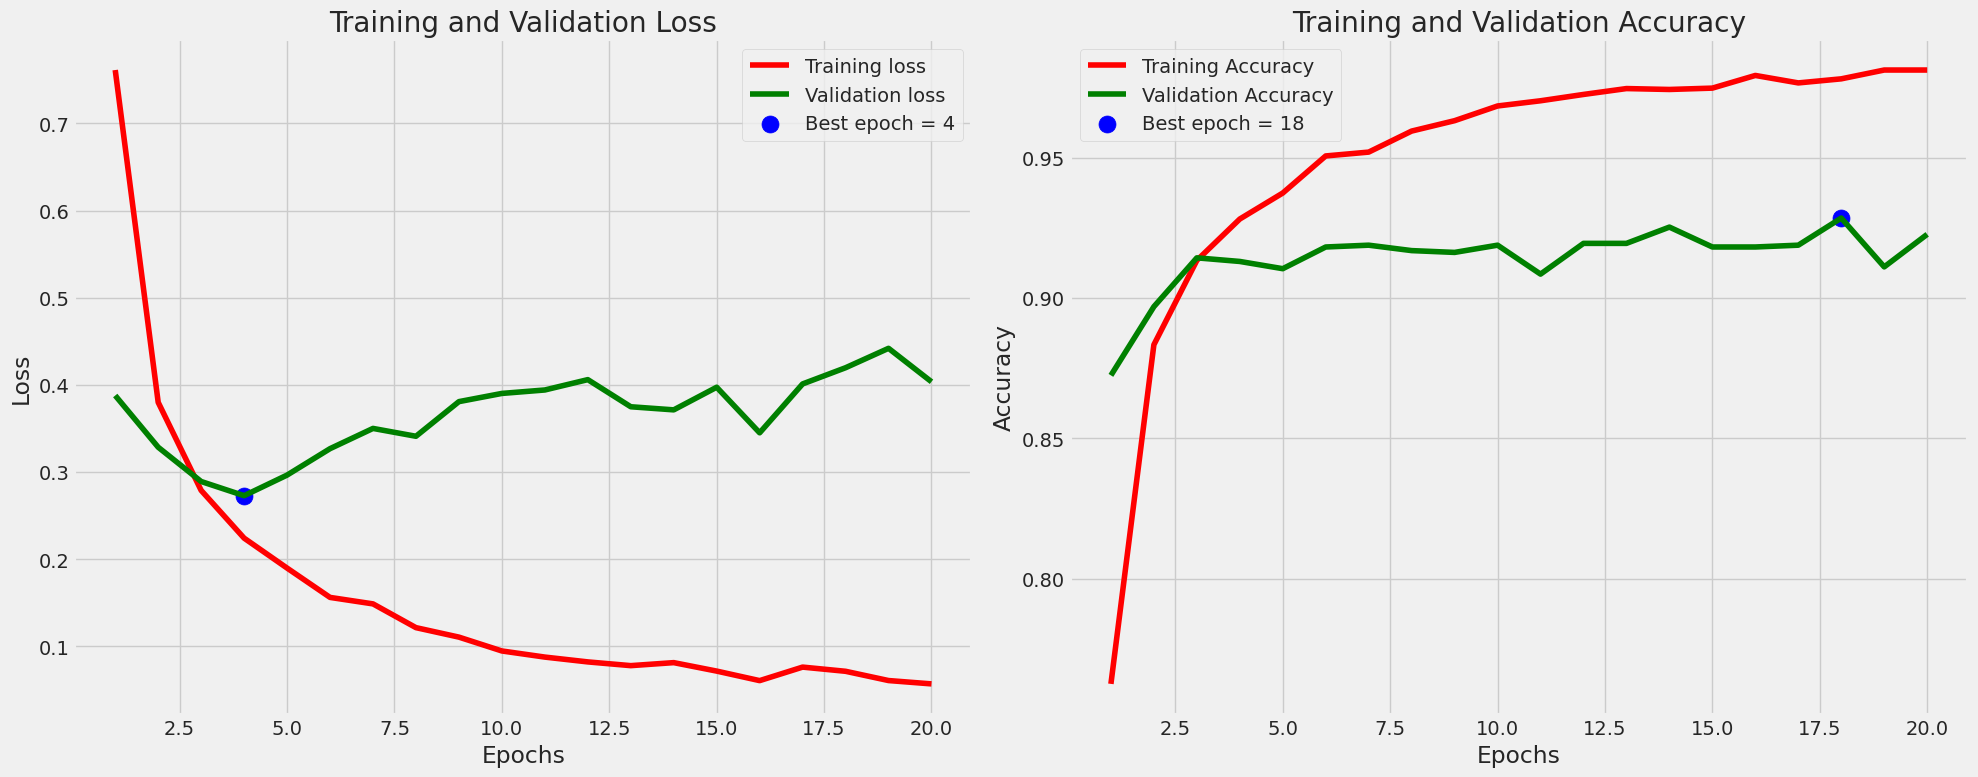

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.9203 - loss: 0.4398
Akurasi pada set pengujian adalah 92.71 %



In [47]:
tr_plot(history, 0)

save_dir = '/content/drive/My Drive/Image Clasification Dicoding/'  # Ubah save_dir ke direktori yang diinginkan
subject = 'Klasifikasi-Sampah-Mod'

acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100
msg = f'Akurasi pada set pengujian adalah {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.h5')
save_loc = os.path.join(save_dir, save_id)
model.save(save_loc)

In [44]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []

    for key, value in class_dict.items():
        new_dict[value] = key  # Mapping class number to class name

    # Save the class mapping to a text file
    classes = list(new_dict.values())  # List of class names
    dict_as_text = str(new_dict)
    dict_name = subject + '-' + str(len(classes)) + '.txt'
    dict_path = os.path.join(save_dir, dict_name)

    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)

    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # Actual class as integer

        if pred_index != true_index:  # Misclassification occurs
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors += 1

        y_pred.append(pred_index)

    if print_code != 0:
        if errors > 0:
            r = min(print_code, errors)
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))

            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'With accuracy of 100 %, no errors to display'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))

    if errors > 0:
        plot_bar = []
        plot_class = []

        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)
                plot_class.append(value)

        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')

        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)

        plt.title('Errors by Class on Test Set')

    y_true = np.array(labels)
    y_pred = np.array(y_pred)

    if len(classes) <= 30:
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)

        fig_width = 8 if length < 8 else int(length * 0.5)
        fig_height = 8 if length < 8 else int(length * 0.5)

        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step


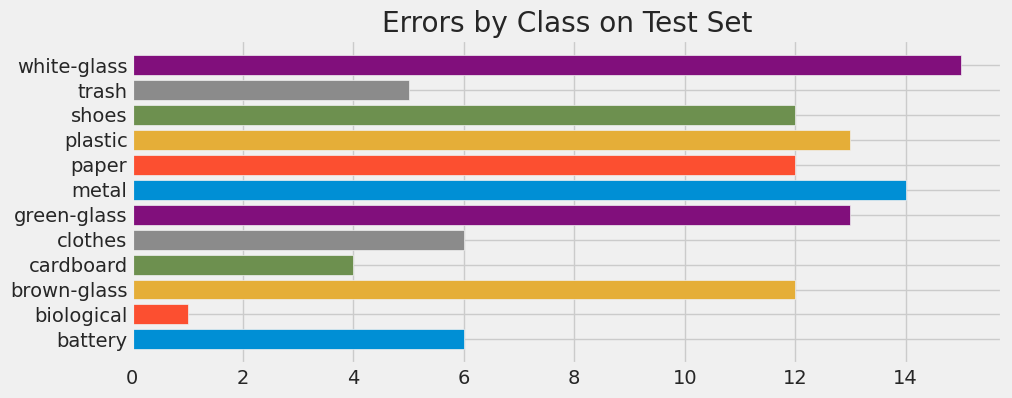

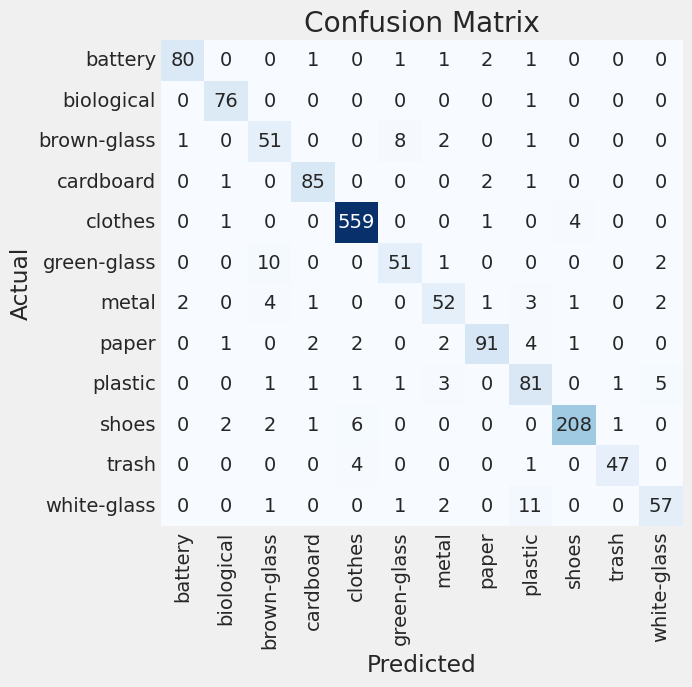

Classification Report:
----------------------
               precision    recall  f1-score   support

     battery       0.96      0.93      0.95        86
  biological       0.94      0.99      0.96        77
 brown-glass       0.74      0.81      0.77        63
   cardboard       0.93      0.96      0.94        89
     clothes       0.98      0.99      0.98       565
 green-glass       0.82      0.80      0.81        64
       metal       0.83      0.79      0.81        66
       paper       0.94      0.88      0.91       103
     plastic       0.78      0.86      0.82        94
       shoes       0.97      0.95      0.96       220
       trash       0.96      0.90      0.93        52
 white-glass       0.86      0.79      0.83        72

    accuracy                           0.93      1551
   macro avg       0.89      0.89      0.89      1551
weighted avg       0.93      0.93      0.93      1551



In [45]:
print_code = 0
predictions = model.predict(test_gen)
print_info(test_gen, predictions, print_code, save_dir, subject) # display_info was changed to print_info

# Konversi Model Yang Ada

In [48]:
import tensorflowjs as tfjs  # Pastikan ini diimpor

# Direktori untuk menyimpan model
save_dir = '/content/drive/My Drive/Image Clasification Dicoding/'
subject = 'klasifikasi-sampah'

# Evaluasi model pada test set
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100

# Simpan model dalam format SavedModel
saved_model_dir = os.path.join(save_dir, 'saved_model')
tf.saved_model.save(model, saved_model_dir)  # Menyimpan model dalam format SavedModel
print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_dir}")

# Simpan model dalam format TF-Lite (tanpa optimasi)
tflite_model_dir = os.path.join(save_dir, 'model.tflite')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_model_dir, 'wb') as f:
    f.write(tflite_model)
print(f"Model berhasil disimpan dalam format TF-Lite (tanpa optimasi) di: {tflite_model_dir}")

# Simpan model dalam format TF-Lite dengan optimasi
tflite_optimized_model_dir = os.path.join(save_dir, 'model_optimized.tflite')

# Mengaktifkan opsi optimasi untuk ukuran dan performa
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi model dengan optimasi
tflite_optimized_model = converter.convert()

# Simpan model TF-Lite yang dioptimasi
with open(tflite_optimized_model_dir, 'wb') as f:
    f.write(tflite_optimized_model)
print(f"Model berhasil disimpan dalam format TF-Lite (dengan optimasi) di: {tflite_optimized_model_dir}")

# Simpan model dalam format TFJS
tfjs_model_dir = os.path.join(save_dir, 'tfjs_model')
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model berhasil disimpan dalam format TFJS di: {tfjs_model_dir}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - accuracy: 0.9203 - loss: 0.4398


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


Model berhasil disimpan dalam format SavedModel di: /content/drive/My Drive/Image Clasification Dicoding/saved_model


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


Saved artifact at '/tmp/tmpto1mc7cx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  139054634652432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634655696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634651472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634652816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634656272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634656464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634655888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634655120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634656656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634654544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


Saved artifact at '/tmp/tmpd_ok1fwl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  139054634652432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634655696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634651472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634652816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634656272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634656464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634655888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634655120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634656656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634654544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054634

Model berhasil disimpan dalam format TF-Lite (dengan optimasi) di: /content/drive/My Drive/Image Clasification Dicoding/model_optimized.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan dalam format TFJS di: /content/drive/My Drive/Image Clasification Dicoding/tfjs_model
